In [ ]:
import os
import zipfile

# Descargar dataset desde Kaggle
dataset_path = "alzheimers_data"
kaggle_dataset = "yiweilu2033/well-documented-alzheimers-dataset"

# Crear la carpeta si no existe
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)
    os.system(f"kaggle datasets download -d {kaggle_dataset} -p {dataset_path} --unzip")
    print("Dataset descargado y descomprimido en:", dataset_path)
else:
    print("El dataset ya está descargado.")


Dataset descargado y descomprimido en: alzheimers_data


In [ ]:
import os


# Verificar si la ruta del dataset existe
if not os.path.exists(dataset_path):
    print("Error: La ruta del dataset no existe.")
else:
    # Diccionario para almacenar el número de imágenes por clase
    image_counts = {}

    # Recorrer las carpetas dentro del dataset
    for class_name in sorted(os.listdir(dataset_path)):  # Ordenar alfabéticamente
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):  # Verificar que es una carpeta
            num_images = 0

            # Recorrer todos los archivos en la carpeta y sus subcarpetas
            for root, _, files in os.walk(class_path):
                num_images += sum(1 for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')))

            image_counts[class_name] = num_images

    # Mostrar el número de imágenes por clase
    for class_name, count in image_counts.items():
        print(f" {class_name}: {count} imágenes")

    # Mostrar total de imágenes en todo el dataset
    total_images = sum(image_counts.values())
    print(f"\n Total de imágenes en el dataset: {total_images}")


 MildDemented: 5184 imágenes
 ModerateDemented: 376 imágenes
 NonDemented (2): 63560 imágenes
 VeryMildDemented: 13796 imágenes

 Total de imágenes en el dataset: 82916


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transformaciones para preprocesar las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajustamos tamaño a 224x224 (más eficiente)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar dataset
dataset_path = "./alzheimers_data"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# División en 80%-10%-10%
train_size = int(0.80 * len(dataset))
val_size = int(0.10 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Asegurar que suman correctamente

torch.manual_seed(42)  # Para reproducibilidad
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear dataloaders
batch_size = 128  # Ajustar según GPU
num_workers = 4  # Ajustar según CPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 66332, Validation: 8291, Test: 8293


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class AlzheimerEfficientNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerEfficientNet, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)  # EfficientNet-B0 (rápido y preciso)

        # Reemplazar la última capa completamente conectada
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Inicializar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerEfficientNet(num_classes=4).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]


In [ ]:
import time
import torch.optim as optim
import torch.nn.functional as F

# Definir loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

def train_val_loop(epochs, patience):
    best_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        # Evaluación en validación
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}, Val Acc {val_acc:.2f}%, Time {time.time() - start_time:.2f}s")

        # Guardar mejor modelo
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Mejor modelo guardado con {val_acc:.2f}% de accuracy")
        else:
            patience_counter += 1
            print(f"No hubo mejora. Paciencia: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early Stopping en la época {epoch+1}. Mejor accuracy: {best_acc:.2f}%")
            break




# Entrenar el modelo
train_val_loop(epochs=20, patience=5)


Epoch 1: Loss 0.4511, Val Acc 84.28%, Time 578.78s
Mejor modelo guardado con 84.28% de accuracy
Epoch 2: Loss 0.2935, Val Acc 92.03%, Time 563.78s
Mejor modelo guardado con 92.03% de accuracy
Epoch 3: Loss 0.1605, Val Acc 97.00%, Time 566.96s
Mejor modelo guardado con 97.00% de accuracy
Epoch 4: Loss 0.0931, Val Acc 98.38%, Time 565.77s
Mejor modelo guardado con 98.38% de accuracy
Epoch 5: Loss 0.0582, Val Acc 99.11%, Time 562.58s
Mejor modelo guardado con 99.11% de accuracy
Epoch 6: Loss 0.0436, Val Acc 99.05%, Time 562.93s
No hubo mejora. Paciencia: 1/5
Epoch 7: Loss 0.0341, Val Acc 99.72%, Time 555.13s
Mejor modelo guardado con 99.72% de accuracy
Epoch 8: Loss 0.0286, Val Acc 99.63%, Time 564.48s
No hubo mejora. Paciencia: 1/5
Epoch 9: Loss 0.0254, Val Acc 99.77%, Time 564.18s
Mejor modelo guardado con 99.77% de accuracy
Epoch 10: Loss 0.0186, Val Acc 99.83%, Time 560.66s
Mejor modelo guardado con 99.83% de accuracy
Epoch 11: Loss 0.0190, Val Acc 99.71%, Time 558.08s
No hubo mejora.

In [ ]:
def evaluate_model():
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Precisión final en Test: {100 * correct / total:.2f}%")

evaluate_model()


<ipython-input-6-fff5caedf501>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Precisión final en Test: 99.95%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch.nn.functional as F

# Clases del dataset
class_names = dataset.classes  # Obtiene nombres de clases desde ImageFolder

def get_predictions(model, dataloader):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []  # Para curva ROC

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)  # Convertimos logits a probabilidades
            _, predicted = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Guardar probabilidades

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

y_true, y_pred, y_probs = get_predictions(model, test_loader)


<ipython-input-7-3f755998f0df>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
/usr/local/lib/python3.11/dist-packages/

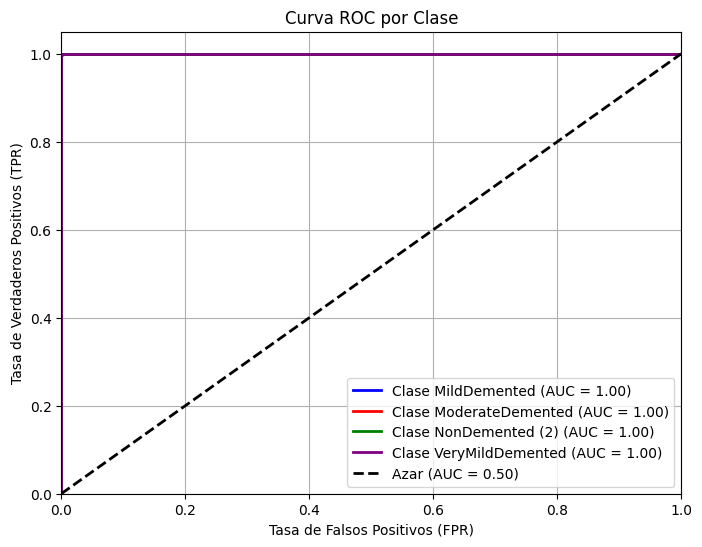

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Obtener la curva ROC para cada clase
def plot_roc_curve(y_true, y_probs, class_names):
    num_classes = len(class_names)
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Convertir etiquetas verdaderas a one-hot encoding
    y_true_one_hot = np.eye(num_classes)[y_true]

    plt.figure(figsize=(8, 6))

    colors = cycle(["blue", "red", "green", "purple"])
    for i, color in zip(range(num_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Clase {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Diagonal (azar)
    plt.plot([0, 1], [0, 1], "k--", lw=2, label="Azar (AUC = 0.50)")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curva ROC por Clase")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar
plot_roc_curve(y_true, y_probs, class_names)


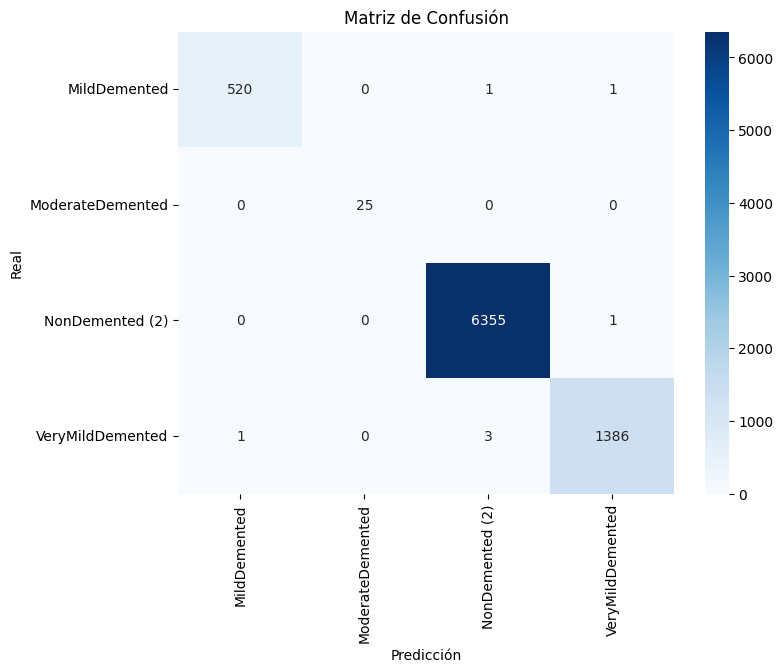

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)


In [ ]:
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))


Reporte de Clasificación:
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       522
ModerateDemented       1.00      1.00      1.00        25
 NonDemented (2)       1.00      1.00      1.00      6356
VeryMildDemented       1.00      1.00      1.00      1390

        accuracy                           1.00      8293
       macro avg       1.00      1.00      1.00      8293
    weighted avg       1.00      1.00      1.00      8293

